In [1]:
import cv2
from skimage.feature import hog
import numpy as np
import glob
from sklearn.svm import LinearSVC
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cross_validation import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import scipy.ndimage as ndim
from datetime import datetime

/home/ubuntu/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
import imageio
imageio.plugins.ffmpeg.download()

In [2]:
def convert_color(img, conv='RGB2HLS'):
    """Converts image to color specified by conv. 
    
    Conversion does not affect the original image.
    
    Args:
        img: the image to convert
        conv: optional variable specifying conversion. 
            RGB2YCrCb, BGR2YCrCb, RGB2LUV, RGB2HLS are
            accepted conversions.  Defaults to RGB2YCrCb"""
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img.copy(), cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img.copy(), cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img.copy(), cv2.COLOR_RGB2HLS)

def get_hog_features(img, orient=9, pix_per_cell=(8,8), cells_per_block=(2,2), 
                        vis=False, feature_vec=True):
        """get_hog_features: Computes hog features on the input img.
    
        Uses skimage.features implemenation of histogram of oriented
        gradients to compute hog features on imput image
        
        Args:
            image : (M, N) ndarray
                Input image (greyscale).
            orientations : int, optional, 9
                Number of orientation bins.
            pix_per_cell : 2-tuple (int, int), optional, (8, 8)
                Size (in pixels) of a cell.
            cells_per_block : 2-tuple (int, int), optional, (2, 2)
                Number of cells in each block.
            vis : boolean, optional, False.
                True returns additional output visualization of hog features
            feature_vec : boolean, optional, True.
                True calls ravel on features before returning
            
            Returns:
                newarr : ndarray
                    HOG for the image as a 1D (flattened) array.
                hog_image : ndarray (if visualise=True)
                    A visualisation of the HOG image.
            """
        return hog(img, orientations=orient, 
                                      pixels_per_cell=pix_per_cell,
                                      cells_per_block=cells_per_block,
                                      transform_sqrt=False,
                                      visualise=vis, feature_vector=feature_vec)
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [3]:
from sklearn.externals import joblib
svc = joblib.load('svc_2018-03-08_22-11-24.sav')
X_scaler = joblib.load('scaler_2018-03-08_22-11-24.sav')

In [ ]:
# train svc
num_samples = 'all'
cars = glob.glob('vehicles/**/*.png')
np.random.shuffle(cars)
not_cars = glob.glob('non-vehicles/**/*.png')
np.random.shuffle(not_cars)
use_colors = True

if num_samples != 'all':
    cars = cars[:num_samples]
    not_cars = not_cars[:num_samples]

total = len(cars) + len(not_cars)


img = mpimg.imread(cars[0]).astype(np.float32)/255
img = convert_color(img)
hogs = np.empty((0))
for i in range(3):
    hogs = np.hstack((hogs, get_hog_features(img[:, :, i])))

if use_colors:
    colors = color_hist(img) 
    feats = np.hstack((hogs, colors))
else:
    feats = hogs

features = np.empty((total, feats.size))
features[0] = feats

for ind,img in enumerate(cars[1:] + not_cars):
    img = mpimg.imread(img).astype(np.float32)/255
    img = convert_color(img)
    hogs = np.empty((0))
    for i in range(3):
        hogs = np.hstack((hogs, get_hog_features(img[:, :, i])))
    if use_colors:
        colors = color_hist(img)
        features[ind+1] = np.hstack((hogs, colors))
    else:
        features[ind+1] = hogs
    if ind % 1000 == 0:
        print('{} percent done'.format(ind/total * 100))

X_scaler = StandardScaler().fit(features)
# Apply the scaler to X
scaled_X = X_scaler.transform(features)

# Define the labels vector
y = np.hstack((np.ones(len(cars)), np.zeros(len(not_cars))))


# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2)

# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these ', n_predict, ' labels: ', y_test[0:n_predict])

#from sklearn.externals import joblib
#joblib.dump(svc, 'svc_{date:%Y-%m-%d_%H-%M-%S}.sav'.format(date=datetime.now()))
#joblib.dump(X_scaler, 'scaler_{date:%Y-%m-%d_%H-%M-%S}.sav'.format(date=datetime.now())) 

In [4]:
def slide_window_over_feats(feats_shape, pix_per_cell=8, window_dims=(64,64), block_stride=1):
    
    cells_per_block_x, cells_per_block_y = feats_shape[2], feats_shape[3]
    
    win_x, win_y = window_dims
    cells_per_win_x = win_x // pix_per_cell
    cells_per_win_y = win_y // pix_per_cell
    
    blocks_per_win_x = cells_per_win_x - cells_per_block_x + 1
    blocks_per_win_y = cells_per_win_y - cells_per_block_y + 1
    
    for yi in range(0, feats_shape[0] + 1 - blocks_per_win_y, block_stride):
        for xi in range(0, feats_shape[1] + 1 - blocks_per_win_x, block_stride):
            yield [(xi, yi), (xi+blocks_per_win_x, yi+blocks_per_win_y)]

In [5]:
# Define a single function that can extract features using 
# hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins):
    
    
    img = img.astype(np.float32)/255.0
    
        
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    if scale != 1:
        img_tosearch = cv2.resize(img_tosearch, (
            np.int(img_tosearch.shape[1]*scale), 
            np.int(img_tosearch.shape[0]*scale)))
        
    ctrans_tosearch = convert_color(img_tosearch)
     
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    
    # Compute individual channel HOG features for the entire image
    pix_tuple = (pix_per_cell, pix_per_cell)
    cells_tuple = (cell_per_block, cell_per_block)
    hog1 = get_hog_features(ch1, orient, pix_tuple, cells_tuple, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_tuple, cells_tuple, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_tuple, cells_tuple, feature_vec=False)
    
    bboxes = []
    for (x1, y1), (x2, y2) in slide_window_over_feats(hog1.shape):
       
        # Extract HOG for this patch
        hog_feat1 = hog1[y1:y2, x1:x2].ravel() 
        hog_feat2 = hog2[y1:y2, x1:x2].ravel() 
        hog_feat3 = hog3[y1:y2, x1:x2].ravel() 
        hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

        xleft = x1*pix_per_cell
        ytop = y1*pix_per_cell

        # Extract the image patch
        subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
          
        # Get color features
        # spatial_features = bin_spatial(subimg, size=spatial_size)
        hist_features = color_hist(subimg, nbins=hist_bins)

        # Scale features and make a prediction
        test_features = X_scaler.transform(np.hstack((hog_features, hist_features)).reshape(1, -1))    
        test_prediction = svc.predict(test_features)
            
        if test_prediction == 1:
            xleft = np.int(xleft/scale) + xstart
            ytop = np.int(ytop/scale) + ystart
            win_sz = np.int(window/scale)
            bboxes.append([(xleft, ytop), (xleft+win_sz,ytop+win_sz)])
            #import pdb; pdb.set_trace()
    return bboxes

In [6]:
# Define a single function that can extract features using 
# hog sub-sampling and make predictions
def draw_boxes(img, ystart, ystop, xstart, xstop, scale, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins):
    
    
    img = img.astype(np.float32)/255.0
    
        
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    if scale != 1:
        img_tosearch = cv2.resize(img_tosearch, (
            np.int(img_tosearch.shape[1]*scale), 
            np.int(img_tosearch.shape[0]*scale)))
        
    ctrans_tosearch = convert_color(img_tosearch)
     
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    
    # Compute individual channel HOG features for the entire image
    pix_tuple = (pix_per_cell, pix_per_cell)
    cells_tuple = (cell_per_block, cell_per_block)
    hog1 = get_hog_features(ch1, orient, pix_tuple, cells_tuple, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_tuple, cells_tuple, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_tuple, cells_tuple, feature_vec=False)
    
    bboxes = []
    for (x1, y1), (x2, y2) in slide_window_over_feats(hog1.shape):
       
        # Extract HOG for this patch
        hog_feat1 = hog1[y1:y2, x1:x2].ravel() 
        hog_feat2 = hog2[y1:y2, x1:x2].ravel() 
        hog_feat3 = hog3[y1:y2, x1:x2].ravel() 
        hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

        xleft = x1*pix_per_cell
        ytop = y1*pix_per_cell

        # Extract the image patch
        subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
          
        # Get color features
        # spatial_features = bin_spatial(subimg, size=spatial_size)
        hist_features = color_hist(subimg, nbins=hist_bins)

        # Scale features and make a prediction
        test_features = X_scaler.transform(np.hstack((hog_features, hist_features)).reshape(1, -1))    
        test_prediction = svc.predict(test_features)
            
        if test_prediction == 1:
            xleft = np.int(xleft/scale) + xstart
            ytop = np.int(ytop/scale) + ystart
            win_sz = np.int(window/scale)
            bboxes.append([(xleft, ytop), (xleft+win_sz,ytop+win_sz)])
            #import pdb; pdb.set_trace()
    return bboxes

In [7]:
class HeatMap:
    def __init__(self, shape=(720, 1280)):
        self._shape = shape 
        self._frame1_boxes = []
        self._frame2_boxes = []
        self._frame3_boxes = []
        
    def add_boxes(self, boxes):
        self._frame3_boxes = self._frame2_boxes
        self._frame2_boxes = self._frame1_boxes
        self._frame1_boxes = boxes
        
    def generate_heatmap(self, threshold=None):
        heatmap = np.zeros(self._shape)
        
        for ((top_left_x, top_left_y), (bottom_right_x, bottom_right_y)) in self._frame1_boxes:
            heatmap[top_left_y:bottom_right_y, top_left_x:bottom_right_x] += 3
            
        for ((top_left_x, top_left_y), (bottom_right_x, bottom_right_y)) in self._frame2_boxes:
            heatmap[top_left_y:bottom_right_y, top_left_x:bottom_right_x] += 2
            
        for ((top_left_x, top_left_y), (bottom_right_x, bottom_right_y)) in self._frame3_boxes:
            heatmap[top_left_y:bottom_right_y, top_left_x:bottom_right_x] += 1
        if threshold is None:
            return heatmap
        
        return heatmap > threshold

In [8]:
def sub_box(b1, b2):
        if b1[0][0] >= b2[0][0] and b1[0][1] >= b2[0][1]:
            if b1[1][0] <= b2[1][0] and b1[1][1] <= b2[1][1]:
                return True    
        return False

def too_small(b, min_x=20, min_y=20, min_area=600):
    len_x = b[1][0] - b[0][0]
    len_y = b[1][1] - b[0][1]
    area = len_x*len_y
    if len_x < min_x:
        return True
    if len_y < min_y:
        return True
    if area < min_area:
        return True
    return False

def cleanup(boxes, clean_boxes):

        if len(boxes) == 0:
            return clean_boxes

        box = boxes[0]
        if too_small(box):
            return cleanup(boxes[1:], clean_boxes)
        
        for other_box in boxes[1:] + clean_boxes:
            # check if box is inside 
            if sub_box(box, other_box):
                return cleanup(boxes[1:], clean_boxes)
        return cleanup(boxes[1:], clean_boxes+[box])

def get_boxes_from_labels(labels):
        boxes = []
            
        for lab in range(labels[1]):
            lab_inds = (labels[0] == lab+1).nonzero()
        
            top_left = (np.min(lab_inds[1]), np.min(lab_inds[0]))
            bottom_right = (np.max(lab_inds[1]), np.max(lab_inds[0]))
            
            box = [top_left, bottom_right]
            boxes.append(box)
    
        
        return cleanup(boxes, [])

In [ ]:
b1 = [(12, 34), (14, 44)]
b2 = [(10, 30), (14, 44)]
b3 = [(10, 30), (15, 45)]
assert(sub_box(b1, b2))
assert(sub_box(b1, b3))
assert(sub_box(b2, b3))
assert(not sub_box(b3, b2))

b1 = [(1091, 468), (1095, 472)]
assert(too_small(b1))
b2 = [(1091, 468), (1295, 572)]
assert(not too_small(b2))

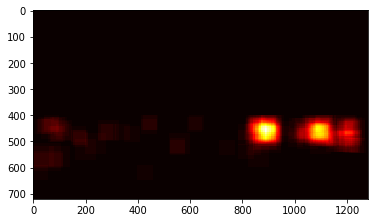

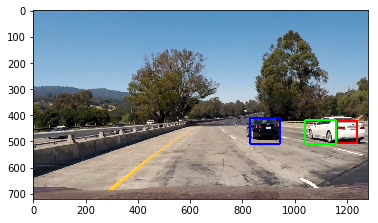

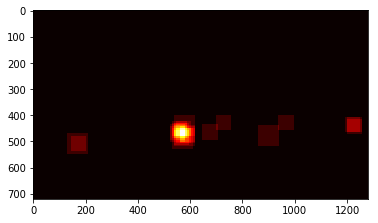

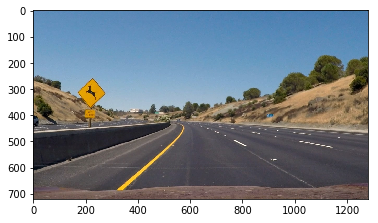

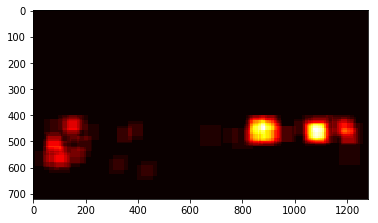

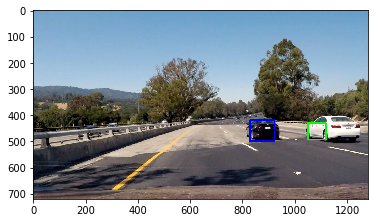

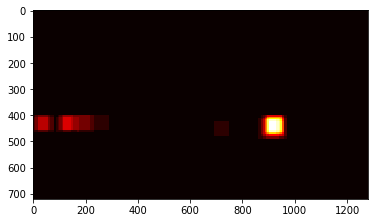

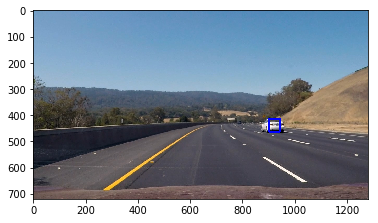

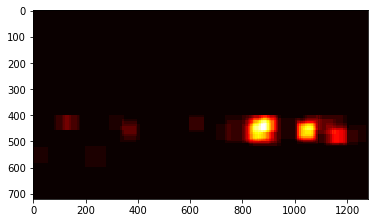

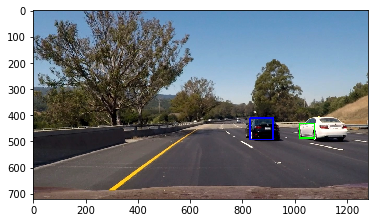

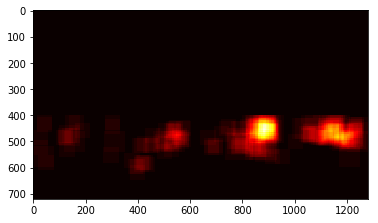

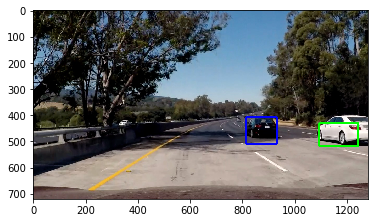

In [9]:
ystart = 400
ystop = 650
scales = [.6, .8, 1, 1.1]
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)
hist_bins = 32
   
for img in glob.glob('test_images/*.jpg'):
    heatmap = HeatMap()
    
    img = mpimg.imread(img)
    draw_im = np.copy(img)

    boxes = []
    for scale in scales:
        boxes += find_cars(img, ystart, ystop, 0, img.shape[1], scale, svc, X_scaler, 
                          orient, pix_per_cell, cell_per_block, 
                          spatial_size, hist_bins)

    heatmap.add_boxes(boxes)
    heat = heatmap.generate_heatmap()
    labels = ndim.label(heat>50)

    boxes = get_boxes_from_labels(labels)

    i = 0
    color = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]
    for box in boxes:
        cv2.rectangle(draw_im, *box, color[i], 6)
        i = (i + 1) % 3

    plt.imshow(heat, cmap='hot')
    plt.show()    

    plt.imshow(draw_im)
    plt.show()




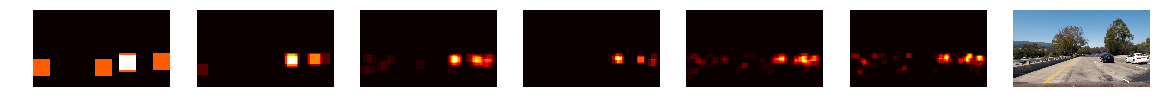

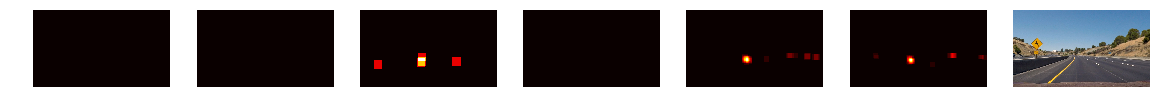

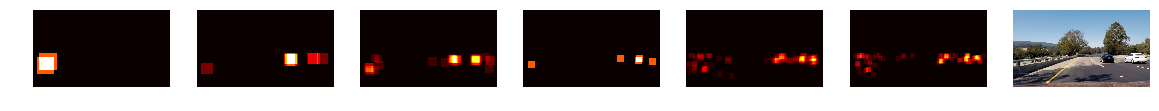

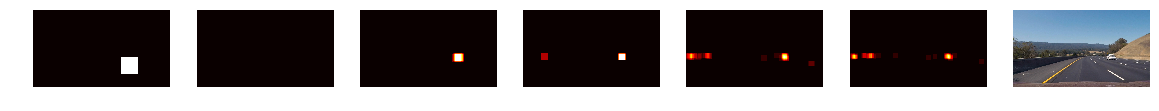

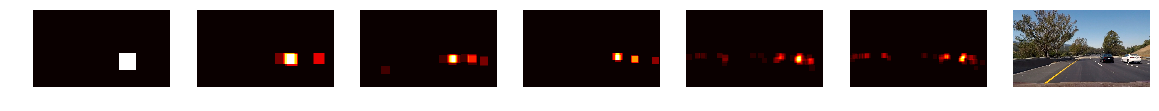

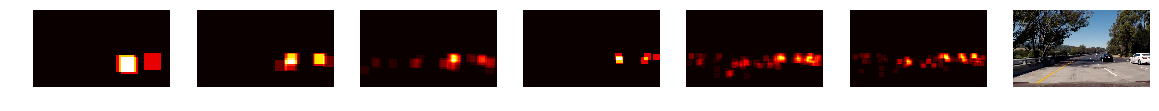

In [10]:
# ystart = 400
ystop = 650
scales = [.4, .6, .8, 1, 1.2, 1.4]
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)
hist_bins = 32
   
for img in glob.glob('test_images/*.jpg'):
    
    img = mpimg.imread(img)
    draw_im = np.copy(img)
    
    plt.figure(figsize=(20,90))
    for si, scale in enumerate(scales):
        heatmap = HeatMap()
        
        boxes = find_cars(img, ystart, ystop, 0, img.shape[1], scale, svc, X_scaler, 
                          orient, pix_per_cell, cell_per_block, 
                          spatial_size, hist_bins)

        heatmap.add_boxes(boxes)
        heat = heatmap.generate_heatmap()
        labels = ndim.label(heat>50)

        boxes = get_boxes_from_labels(labels)

        i = 0
        color = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]
        for box in boxes:
            cv2.rectangle(draw_im, *box, color[i], 6)
            i = (i + 1) % 3

        plt.subplot(1, len(scales)+1, si+1)
        plt.imshow(heat, cmap='hot')
        plt.axis('off')
        
    plt.subplot(1, len(scales)+1, len(scales)+1)
    plt.imshow(img)
    plt.axis('off')
    plt.savefig('heatmaps.jpg')
    plt.show()    



In [11]:
heatmap = HeatMap((720, 1280))

def process_frame(img):
    global heatmap
    
    ystart = 400
    ystop = 650
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (32, 32)
    hist_bins = 32
    draw_im = np.copy(img)
    
    boxes = []
    for scale in [.6, .8, 1, 1.1]:
        boxes += find_cars(img, ystart, ystop, 0, img.shape[1], scale, svc, X_scaler, 
                      orient, pix_per_cell, cell_per_block, 
                      spatial_size, hist_bins)

    
    heatmap.add_boxes(boxes)
    heatmap_out = heatmap.generate_heatmap(threshold=50)
    labels = ndim.label(heatmap_out)
    boxes = get_boxes_from_labels(labels)
    
    for box in boxes:
        cv2.rectangle(draw_im, *box, (255, 0, 0), 6)
        
    plt.figure()
    plt.imshow(draw_im)
    plt.show()
    
    return draw_im

In [ ]:
video_in = 'test_video.mp4'
video_out = 'test_video_out.mp4'
clip = VideoFileClip(video_in)
proc_clip = clip.fl_image(process_frame) #NOTE: this function expects color images!!
%time proc_clip.write_videofile(video_out, audio=False)

In [ ]:
heat = heatmap.generate_heatmap()
np.max(heat[np.where(heat != 0)])

In [ ]:
video_in = 'project_video.mp4'
video_out = 'project_video_out.mp4'
clip = VideoFileClip(video_in)
proc_clip = clip.fl_image(process_frame) #NOTE: this function expects color images!!
%time proc_clip.write_videofile(video_out, audio=False)

In [12]:
video_out = 'project_video_out.mp4'
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(video_out))